# Project 6

Robust line fitting using RANSAC algorithm

## Idea

- Given a hypothesized line
- Count the number of points that “agree” with the line
  - “Agree” = within a small distance of the line 
  - I.e., the inliers to that line
- For all possible lines, select the one with the largest number of inliers

## How do we find the best line?

- Unlikeleast-squares, no simple closed-form solution
- Hypothesize and test
  - Try out many lines, keep the best one 
  - But, which lines?

![](https://raw.githubusercontent.com/m-inh/i116-assignments/master/img/6_1.png)

![](https://raw.githubusercontent.com/m-inh/i116-assignments/master/img/6_2.png)

## RANSAC algorithm

1. Sample (randomly) the number of points required to fit the model (eg: 2)
1. Solve for model parameters using samples
1. Score by the fraction of inliers within a preset threshold of the model

**Repeat** 1-3 until the best model is found with high confidence

*Step 1*
![1](https://raw.githubusercontent.com/m-inh/i116-assignments/master/img/6_3.png)

*Step 2*
![2](https://raw.githubusercontent.com/m-inh/i116-assignments/master/img/6_4.png)

*Step 3*
![3](https://raw.githubusercontent.com/m-inh/i116-assignments/master/img/6_5.png)

*repeat 1-3 to find best model*
![repeat](https://raw.githubusercontent.com/m-inh/i116-assignments/master/img/6_6.png)




In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [0]:
class Point2D:
  """Represent a 2-dimentional point in Euclidean space

  Attributes
  ----------
  x, y: float

  """
  def __init__(self, x, y):
    self.x = x
    self.y = y



class Line2D:
  """Represent a 2-dimentional line in Euclidean space
     The function of line has format: y = ax + b
     
  Attributes
  ----------
  a, b: float

  """
  def __init__(self, a, b):
    self.a = a
    self.b = b

  def find_y(self, x):
    return self.a*x + self.b

In [0]:
# Visualize sample data
def visualize_sample(ps):
  plt.axis("equal")

  # Draw points
  for p in ps:
    plt.scatter(p.x, p.y, color='r')

  plt.show()

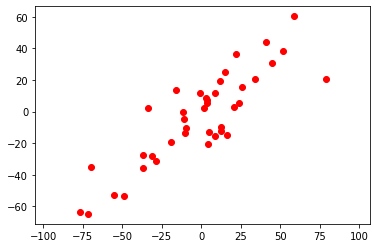

In [0]:
# Prepare sample data
n = 40
pxs, pys = datasets.make_regression(n_samples=40, n_features=1, noise=15)
pxs = pxs * 40
ps = []
for i in range(len(pxs)):
  ps.append(Point2D(pxs[i], pys[i]))


visualize_sample(ps)

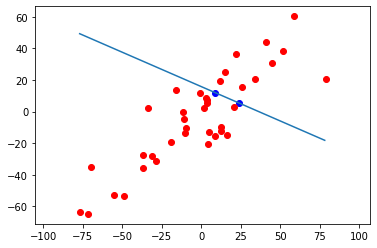

In [0]:
"""This section is prepared for 1st step and 2nd step in RANSAC algorithm

   1st step: Sample (randomly) the number of points required to fit the model
   2nd step: Solve for model parameters using random samples in 1st step
"""

# 1st step: Randomly choose 2 points
def choose_random(ps):
  i1 = int(np.random.uniform(0, len(ps)))
  i2 = int(np.random.uniform(0, len(ps)))
  while (i1 == i2):
    i2 = int(np.random.uniform(0, len(ps)))
  return [ps[i1], ps[i2]]



# 2nd step: Build line that contains 2 random points
def make_line(p1, p2):
  # y = ax + b
  # -> a = (y1-y2) / (x1-x2)
  # -> b = y1 - ax1
  a = (p1.y - p2.y) / (p1.x - p2.x)
  b = p1.y - (a*p1.x)
  return Line2D(a, b)



"""This section is for testing
   
   Functions are tested:
   - choose_random
   - make_line

   If a figure is drawn correctly, the test is success
"""
# Visualize sample data with random line
def visualize_sample_with_line(ps, l, rps):
  line_x = np.arange(min(pxs), max(pxs))
  line_y = []
  for x in line_x:
    line_y.append(l.find_y(x))

  plt.axis('equal')
  
  # Draw line
  plt.plot(line_x, line_y)

  # Draw points
  for p in ps:
    if len(rps) > 0 and ((p.x == rps[0].x and p.y == rps[0].y) or (p.x == rps[1].x and p.y == rps[1].y)):
      plt.scatter(p.x, p.y, color='b')
    else:
      plt.scatter(p.x, p.y, color='r')

  plt.show()

r_p1, r_p2 = choose_random(ps)
line = make_line(r_p1, r_p2)

visualize_sample_with_line(ps, line, [r_p1, r_p2])

In [0]:
"""This section is prepared for the 3rd step and the repeat procedure in RANSAC algorithm
   
   3rd step: Score by the fraction of inliers within a preset threshold of the model
   Repeat procedure: Repeate 1-3 until the best model is found with high confidence
"""

def common_point(line1, line2):
  # y0 = ax0 + b
  # y0 = a'x0 + b'
  # -> x0 = (b-b') / (a'-a)
  # -> y0 = ax0 + b
  x0 = (line1.b-line2.b) / (line2.a-line1.a)
  y0 = (line1.a*x0) + line1.b
  return Point2D(x0, y0)

def distance_point_to_point(p1, p2):
  a = p1.x - p2.x
  b = p1.y - p2.y
  return math.sqrt((a*a) + (b*b))

def distance_line_to_point(line1, p):
  # y = ax + b
  # y = (-1/a)x + b'
  # -> b' = y0 + (1/a)x0
  a2 = -1 / line1.a
  b2 = p.y + (p.x/line1.a)
  line2 = Line2D(a2, b2)

  c_point = common_point(line1, line2)
  return distance_point_to_point(p, c_point)

def score(ps, line, th):
  inliers_count = 0
  inliers = []
  
  for i in range(len(ps)):
    delta = distance_line_to_point(line, ps[i])
    if (delta <= th):
      inliers_count += 1
      inliers.append(True)
    else:
      inliers.append(False)
  
  return inliers_count, inliers


# Visualize sample data with random line with inliers
def visualize_all(ps, l, rps, inliers, current_score, threshold, iter):
  line_x = np.arange(min(pxs), max(pxs), 0.01)
  line_y = []
  for x in line_x:
    line_y.append(l.find_y(x))
  
  # Draw line
  plt.plot(line_x, line_y)

  # Draw points
  for i in range(len(ps)):
    p = ps[i]
    if ((p.x == rps[0].x and p.y == rps[0].y) or (p.x == rps[1].x and p.y == rps[1].y)):
      plt.scatter(p.x, p.y, color='b')
    elif inliers[i] == True:
      plt.scatter(p.x, p.y, color='g')
    else:
      plt.scatter(p.x, p.y, color='r')

  plt.xlabel("step: " + str(iter) + ", threshold: " + str(threshold) + ", inliers: " + str(current_score))
  plt.show()


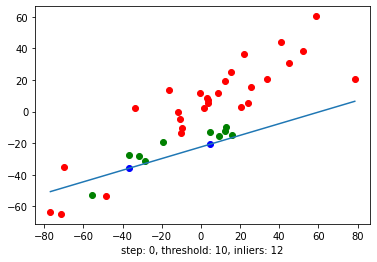

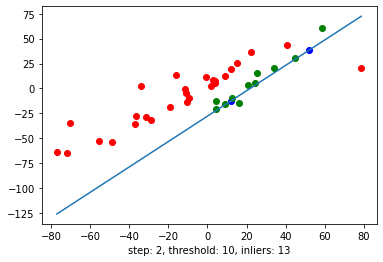

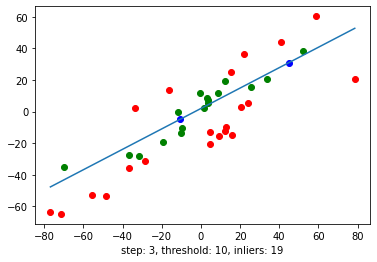

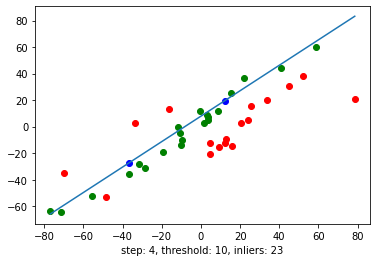

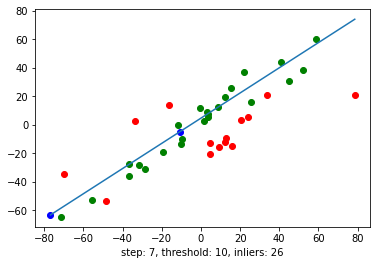

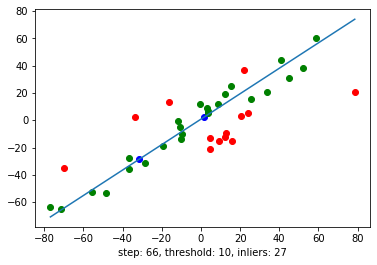

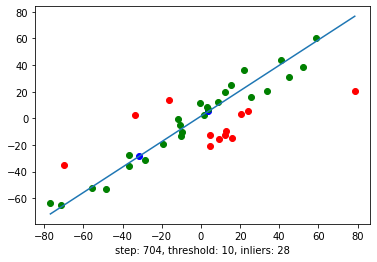

In [0]:
"""This section is for testing
   
   Functions are tested:
   - choose_random
   - make_line
   - score

   If some figures is drawn correctly, the test is success
"""
threshold = 10
max_try = 1000
best_score = 0
best_line = Line2D(0, 0)
best_inliers = []
best_random_points = []

for i in range(max_try):
  r_p1, r_p2 = choose_random(ps)
  current_line = make_line(r_p1, r_p2)
  current_score, current_inliers = score(ps, current_line, threshold)
  if (current_score > best_score):
    best_score = current_score
    best_line = current_line
    best_inliers = current_inliers
    best_random_points = [r_p1, r_p2]
    
    visualize_all(ps, best_line, best_random_points, best_inliers, current_score, threshold, i)